In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import sph_harm

In [129]:
## constants used in Salazar & Wordsworth, 2023

n = 2*np.pi/(224*60*60*24) # orbital mean motion [rad/s]
Cs_land = 1000000 # heat capacity of surface, [J kg-1]
cp = 1000 # specific heat of air, [J kg-1 K-1]
rho_mean = 5510 # density of planet, [kg m-3]
D = 1.66 # diffusivity constant 
R = 188 # specific gas constant, [J kg-1 K-1]
Cd = 0.0034 # surface drag coefficient
chi = 0.17 # reference thermal coupling factor
I = 0.4*M_E*R_E**2 # principle moment of inertia of planet
k2 = 0.23 # second order love number

##  fundamental constants

R_E = 6.378e6 # [m], radius of Earth
M_E = 5.974e24 # [kg], mass of Earth
M_sun = 1.989e30 # [kg], mass of Sun
AU = 1.4959e11 # [m], Earth-sun distance
g = 9.81 # [m s-1], Earth acceleration due to gravity
bar = 1e5 # [Pa]
L_sun = 3.827e26 # [W], luminosity of sun
G = 6.673e-11 # [m3 kg-1 s-2], Gravitational Constant
sigma_SB = 5.67e-8 # Stefan-Boltzmann constant [W m-2 K-4]

In [123]:
def wind_speed(S, alpha, tau_sw, tau_lw, ps): # Us [m/s], Equation (23)
    k = tau_sw/tau_lw 
    F_bar = S*(1-alpha)*np.exp(-tau_sw)/np.pi # average incident stellar radiation at surface (Wm-2)
    SLW = S*(1-alpha)/8*(1+D/k - (1+D/k)*np.exp(-k*tau_lw)) # surface downwelling longwave (Wm-2), Equation (15)
    T_bar = np.power((F_bar+SLW)/sigma_SB, 1/4) # average surface temperature (K)
    T_eq = (S*(1-alpha)/(4*sigma_SB))**(1/4) # equilibrium surface temperature (K)
    Us = np.power(R/Cd * np.maximum((T_bar - T_eq),0.01) * (S/2)*(1-alpha)*np.exp(-tau_sw)*(1-np.exp(-tau_lw))/ps,1/3) 
    return(Us)

def qo_wo(S, alpha, tau_sw, tau_lw, ps): # output q_o (defined in Equation 29) and w_o
    k = tau_sw/tau_lw
    F_bar = S*(1-alpha)*np.exp(-tau_sw)/np.pi # average incident stellar radiation at surface (Wm-2)
    SLW = S*(1-alpha)/8*(1+D/k - (1+D/k)*np.exp(-k*tau_lw)) # surface downwelling longwave (Wm-2), Equation (15)
    T_bar = np.power((F_bar+SLW)/sigma_SB, 1/4) # average surface temperature (K)
    T_eq = (S*(1-alpha)/(4*sigma_SB))**(1/4) # equilibrium surface temperature (K)
    Us = wind_speed(S, alpha, tau_sw, tau_lw, ps)
    circ_strength = Us/Uso # circulation strength, Equation (22)
    delt_p = chi*ps*circ_strength # Equation (23)
    Cs = cp*delt_p/g + Cs_land # heat capacity of surface, including atmosphere
    w_o = 4*sigma_SB*T_bar**3/Cs # thermal equilibrium frequency
    qo = -(1/24)*np.sqrt(15/(2*np.pi))*S*(1-alpha)*np.exp(-tau_sw)*delt_p/(F_bar + SLW)
    return(qo, w_o)

def torque_analytic(S, alpha, tau_sw, tau_lw, ps, Omega, n): # q_tilde [Pa], Equation (29)
    qo, w_o = qo_wo(S, alpha, tau_sw, tau_lw, ps)
    if type(Omega) == str:
        sigma = w_o*1 # maximum thermal tide at Omega = w_o
    else:
        sigma = 2*(Omega-n)
    torque = -qo*sigma/w_o/(1+(sigma/w_o)**2) # Equation (29)
    return(torque)


def amp_analytic(S, alpha, tau_sw, tau_lw, ps, Omega, n): # q_norm [Pa], Equation (30)
    qo, w_o = qo_wo(S, alpha, tau_sw, tau_lw, ps)
    if type(Omega) == str:
        sigma = w_o*1 # maximum thermal tide at Omega = w_o
    else:
        sigma = 2*(Omega-n)
    amp = -qo/np.sqrt(1+(sigma/w_o)**2) # Equation (30)
    return(amp)


def lag_analytic(S, alpha, tau_sw, tau_lw, ps, Omega, n): # sin(2d), Equation (31)
    qo, w_o = qo_wo(S, alpha, tau_sw, tau_lw, ps)
    if type(Omega) == str:
        sigma = w_o*1 # maximum thermal tide at Omega = w_o
    else:
        sigma = 2*(Omega-n)
    lag = np.sin(-np.arctan(-sigma/w_o)) # Equation (31)
    return(lag)


def thermal_tide_torque(M, R_E, a,S, alpha, tau_sw, tau_lw, ps, Omega_list, n): # T_a, Equation (32)
    Ka = -(3/2)*3*M*R_E**3/((5*rho_mean*a**3)*np.sqrt(10/(3*np.pi)))
    q_tilde = torque_analytic(S, alpha, tau_sw, tau_lw, ps, Omega_list, n)
    return(-Ka*q_tilde)

def gravitational_tide_torque(M, R_E, a,Q,Qn, k2, Omega_list, n): # T_g, Equation (4)
    Kg = -(3/2)*G*M**2*R_E**5/a**6
    bg = k2/Q * np.sign(Omega_list-n) 
    return(Kg*bg)

def S_from_a(M, a):
    mu = np.log10(M/M_sun)
    L_star = L_sun * 10**(4.101*mu**3 + 8.162*mu**2 + 7.108*mu) # Equation (37)
    S = L_star/(4*np.pi*a**2) # stellar constant
    orbit_period = (a**3 * 4* np.pi**2/(G*M))**(1/2)
    return(S, 2*np.pi/orbit_period)

def eq_rotation_ana(M, R_E, a, alpha, tau_sw, tau_lw, ps, Q, Qn, k2): # equilibrium rotation rate, Equation (35)
    S, n = S_from_a(M,a)
    qo, w_o = qo_wo(S, alpha, tau_sw, tau_lw, ps)
    Ka = -(3/2)*3*M*R_E**3/((5*rho_mean*a**3)*np.sqrt(10/(3*np.pi)))
    Tg = gravitational_tide_torque(M, R_E, a,Q,Qn, k2, 2*n, n)
    B = -Tg/(Ka*qo)
    if 1 >= 4*B**2: 
        quad_form = (1 + np.sqrt(1-(4*B**2)))/(2*B) # stable equilibria
    else: # no asynchronous solution
        quad_form = 0 # tidally locked
    return(quad_form*w_o)

def critical_semimajor(S, M, R_E, alpha, tau_sw, tau_lw, ps, Q, Qn, k2):
    qo = qo_wo(S, alpha, tau_sw, tau_lw, ps)[0]
    return((10*np.pi/3)**(1/6)*np.power(G*M*R_E**2*k2*rho_mean/(qo*Q),1/3)/AU)
    
def critical_semimajor_leconte(M, R_E, ps, Q, Qn, k2):
    if ps == 10*bar:
        qo = 4080 # Table 1 (Leconte et al. 2015)
    elif ps == 1*bar:
        qo = 1180 # Table 1 (Leconte et al. 2015)
    return((10*np.pi/3)**(1/6)*np.power(G*M*R_E**2*k2*rho_mean/(qo*Q),1/3)/AU)
    
    

In [90]:
Uso = wind_speed(1137, 0.2, 0.00001, 1, 1*bar) # U_so [m/s]

## Figure 4, $\frac{d\Omega}{dt}$

Text(-0.15, 1.05, 'D')

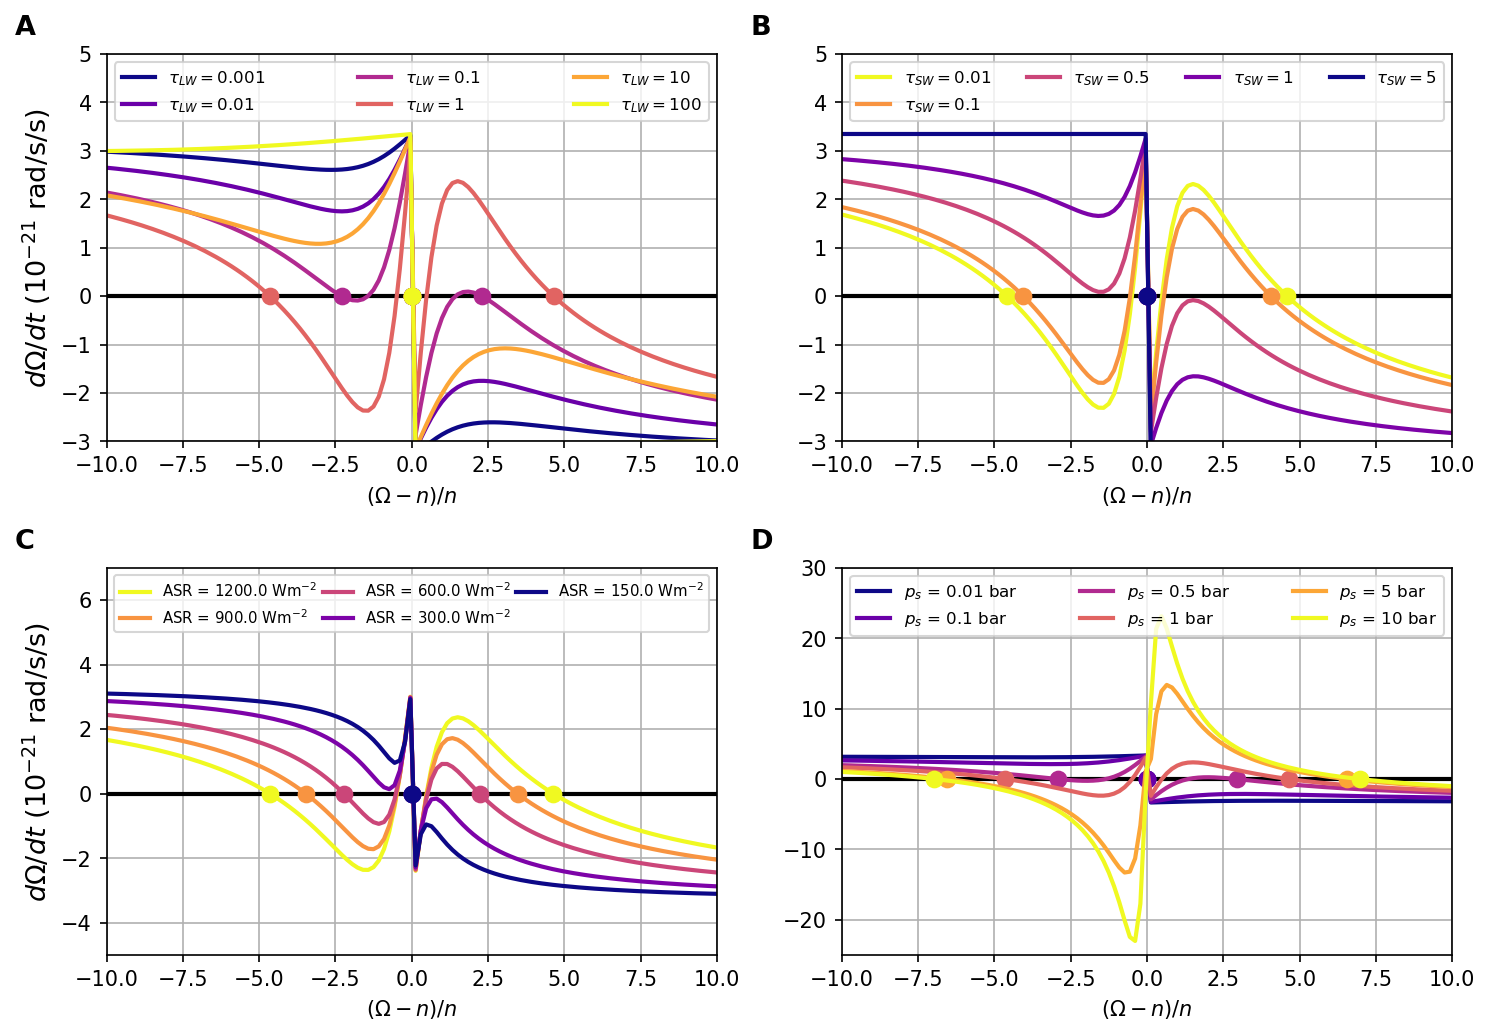

In [132]:
fig, ax = plt.subplots(2,2,figsize=(10,7), dpi=150, tight_layout=True)
Omega_list = np.linspace(-20*n, 21*n, 250)
taulw_list_fig4 = [1e-3, 1e-2, 1e-1, 1, 10, 100]
color= plt.cm.plasma(np.linspace(0,1,len(taulw_list_fig4)))
M_fig4 = 0.7*M_sun
a_fig4 = 0.33*AU
Tg = gravitational_tide_torque(M_fig4, R_E, a_fig4, 100,100, k2, Omega_list, n)


ax[0,0].axhline(y=0, linewidth = 2, color = 'k')
ax[0,1].axhline(y=0, linewidth = 2, color = 'k')
ax[1,0].axhline(y=0, linewidth = 2, color = 'k')
ax[1,1].axhline(y=0, linewidth = 2, color = 'k')

for i in range(len(taulw_list_fig4)):
    S, n = S_from_a(M_fig4,a_fig4)
    Ta = thermal_tide_torque(M_fig4, R_E, a_fig4, S, 0.2, 0.0001, taulw_list_fig4[i], 1*bar, Omega_list,n)
    eq_rot_analytic = eq_rotation_ana(M_fig4, R_E, a_fig4, 0.2, 0.0001, taulw_list_fig4[i], 1*bar, 100, 100, k2)/2 # returns 2(Omega-n)
    ax[0,0].plot((Omega_list-n)/n, 1e21*(Ta + Tg)/I , '-', color = color[i], linewidth = 2,label = '$\\tau_{LW} = $' + str(taulw_list_fig4 [i]))
    ax[0,0].plot([-eq_rot_analytic/n, eq_rot_analytic/n], [0,0],'.', color = color[i],markersize = 15)

ax[0,0].legend(ncol =3, mode='expand', fontsize=8)
ax[0,0].grid()
ax[0,0].set_ylabel('$d\Omega/dt$ ($10^{-21}$ rad/s/s)', fontsize = 13)
ax[0,0].set_xlabel('$(\\Omega -n)/n$')



tausw_list_fig4 = [1e-2, 1e-1, 0.5, 1, 5]
color= plt.cm.plasma_r(np.linspace(0,1,len(tausw_list_fig4)))
for i in range(len(tausw_list_fig4)):
    S, n = S_from_a(M_fig4,a_fig4)
    Ta = thermal_tide_torque(M_fig4, R_E, a_fig4, S, 0.2, tausw_list_fig4[i],1,1*bar, Omega_list, n)
    eq_rot_analytic = eq_rotation_ana(M_fig4, R_E, a_fig4,0.2, tausw_list_fig4[i],1, 1*bar, 100, 100, k2)/2
    ax[0,1].plot((Omega_list-n)/n, 1e21*(Tg+Ta)/I, '-', color = color[i], linewidth = 2,label = '$\\tau_{SW} = $' + str(tausw_list_fig4[i]))
    ax[0,1].plot([-eq_rot_analytic/n, eq_rot_analytic/n], [0,0],'.', color = color[i],markersize = 15)
ax[0,1].legend(ncol =4, mode='expand', fontsize=8)
ax[0,1].grid()
ax[0,1].set_xlabel('$(\\Omega -n)/n$')



alpha_list_fig4 = [0.2,0.4,0.6,0.8,0.9]
color= plt.cm.plasma_r(np.linspace(0,1,len(alpha_list_fig4)))
for i in range(len(alpha_list_fig4)):
    S, n = S_from_a(M_fig4,a_fig4)
    Ta = thermal_tide_torque(M_fig4, R_E, a_fig4,S, alpha_list_fig4[i], 0.001,1,1*bar, Omega_list, n)
    eq_rot_analytic = eq_rotation_ana(M_fig4, R_E, a_fig4,alpha_list_fig4[i], 0.001, 1, 1*bar, 100, 100, k2)/2
    ax[1,0].plot((Omega_list-n)/n, 1e21*(Tg+Ta)/I, '-', color = color[i], linewidth = 2,label = 'ASR = ' + str(np.round(S*(1-alpha_list_fig4[i]),-1)) + ' Wm$^{-2}$')
    ax[1,0].plot([-eq_rot_analytic/n, eq_rot_analytic/n], [0,0],'.', color = color[i],markersize = 15)
    
ax[1,0].legend(ncol =3, mode='expand', fontsize=7.2)
ax[1,0].grid()
ax[1,0].set_ylabel('$d\Omega/dt$ ($10^{-21}$ rad/s/s)', fontsize = 13)
ax[1,0].set_xlabel('$(\\Omega -n)/n$')



ps_list_fig4 = [1e-2, 1e-1, 0.5,1, 5,10]
color= plt.cm.plasma(np.linspace(0,1,len(ps_list_fig4)))
for i in range(len(ps_list_fig4)):
    S, n = S_from_a(M_fig4,a_fig4)
    Ta = thermal_tide_torque(M_fig4, R_E, a_fig4,S, 0.2, 0.001,1,ps_list_fig4[i]*bar, Omega_list, n)
    eq_rot_analytic = eq_rotation_ana(M_fig4, R_E, a_fig4,0.2, 0.0001, 1,ps_list_fig4[i]*bar,100, 100, k2)/2
    ax[1,1].plot((Omega_list-n)/n, 1e21*(Tg+Ta)/I, '-', color = color[i], linewidth = 2,label = '$p_s$ = ' + str(ps_list_fig4[i]) + ' bar')
    ax[1,1].plot([-eq_rot_analytic/n, eq_rot_analytic/n], [0,0],'.', color = color[i],markersize = 15)
ax[1,1].legend(ncol =3, mode='expand', fontsize=8)
ax[1,1].grid()
ax[1,1].set_xlabel('$(\\Omega -n)/n$')




ax[0,0].set_xlim(-10,10)
ax[0,1].set_xlim(-10,10)
ax[1,0].set_xlim(-10,10)
ax[1,1].set_xlim(-10,10)

ax[0,0].set_ylim(-3,5)
ax[0,1].set_ylim(-3,5)
ax[1,0].set_ylim(-5,7)
ax[1,1].set_ylim(-25,30)

ax[0,0].text(-0.15, 1.05,'A', transform=ax[0,0].transAxes, size=13, weight='bold')
ax[0,1].text(-0.15, 1.05,'B', transform=ax[0,1].transAxes, size=13, weight='bold')
ax[1,0].text(-0.15, 1.05,'C', transform=ax[1,0].transAxes, size=13, weight='bold')
ax[1,1].text(-0.15, 1.05,'D', transform=ax[1,1].transAxes, size=13, weight='bold')

#plt.savefig('./Paper Plots/eq_rot_sens_test.pdf', bbox_inches = 'tight')

## Figure 5, Equilibrium rotation rate, $\tau_{LW}$ and $p_{S}$

In [133]:
## tau_lw and ps

taulw_contour_list = 10**np.linspace(-4, 3,110)
ps_contour_list = 10**np.linspace(-2, 3,100)*1e5
alpha_contour_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
M_star_list = [0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

eq_rot_contour_taulwps = np.zeros([len(M_star_list),len(alpha_contour_list),len(taulw_contour_list), len(ps_contour_list)])

for m in range(len(M_star_list)):
    M = M_star_list[m]*M_sun
    mu_star = np.log10(M/M_sun)
    L_star = L_sun*10**(4.101*mu_star**3 + 8.162*mu_star**2 + 7.108*mu_star)
    a_midHZ = AU*(L_star/L_sun)**(1/2)
    orbit_period = (a_midHZ**3 * 4* np.pi**2/(G*M))**(1/2)
    n = 2*np.pi/orbit_period
    for k in range(len(alpha_contour_list)):
        for i in range(len(taulw_contour_list)):
            for j in range(len(ps_contour_list)):
                tau_sw = 0.1
                rot = eq_rotation_ana(M, R_E, a_midHZ, alpha_contour_list[k], tau_sw, taulw_contour_list[i], ps_contour_list[j], 90, 100, k2) # returns 2*sigma
                eq_rot_contour_taulwps[m,k,i,j] = (rot/2+n)/(n)



<ipython-input-135-20d0faa36a76>:16: UserWarning: No contour levels were found within the data range.
  ax[i,j].contour(ps_contour_list/bar, taulw_contour_list, eq_rot_contour_taulwps_plot[i,j,2], levels = [0], colors = 'red')
<ipython-input-135-20d0faa36a76>:17: UserWarning: No contour levels were found within the data range.
  ax[i,j].contour(ps_contour_list/bar, taulw_contour_list, eq_rot_contour_taulwps_plot[i,j,5], levels = [0], colors = 'orange')
<ipython-input-135-20d0faa36a76>:18: UserWarning: No contour levels were found within the data range.
  ax[i,j].contour(ps_contour_list/bar, taulw_contour_list, eq_rot_contour_taulwps_plot[i,j,7], levels = [0], colors = 'yellow')
<ipython-input-135-20d0faa36a76>:19: UserWarning: No contour levels were found within the data range.
  ax[i,j].contour(ps_contour_list/bar, taulw_contour_list, eq_rot_contour_taulwps_plot[i,j,-1], levels = [0], colors = 'blue')
<ipython-input-135-20d0faa36a76>:16: UserWarning: No contour levels were found withi

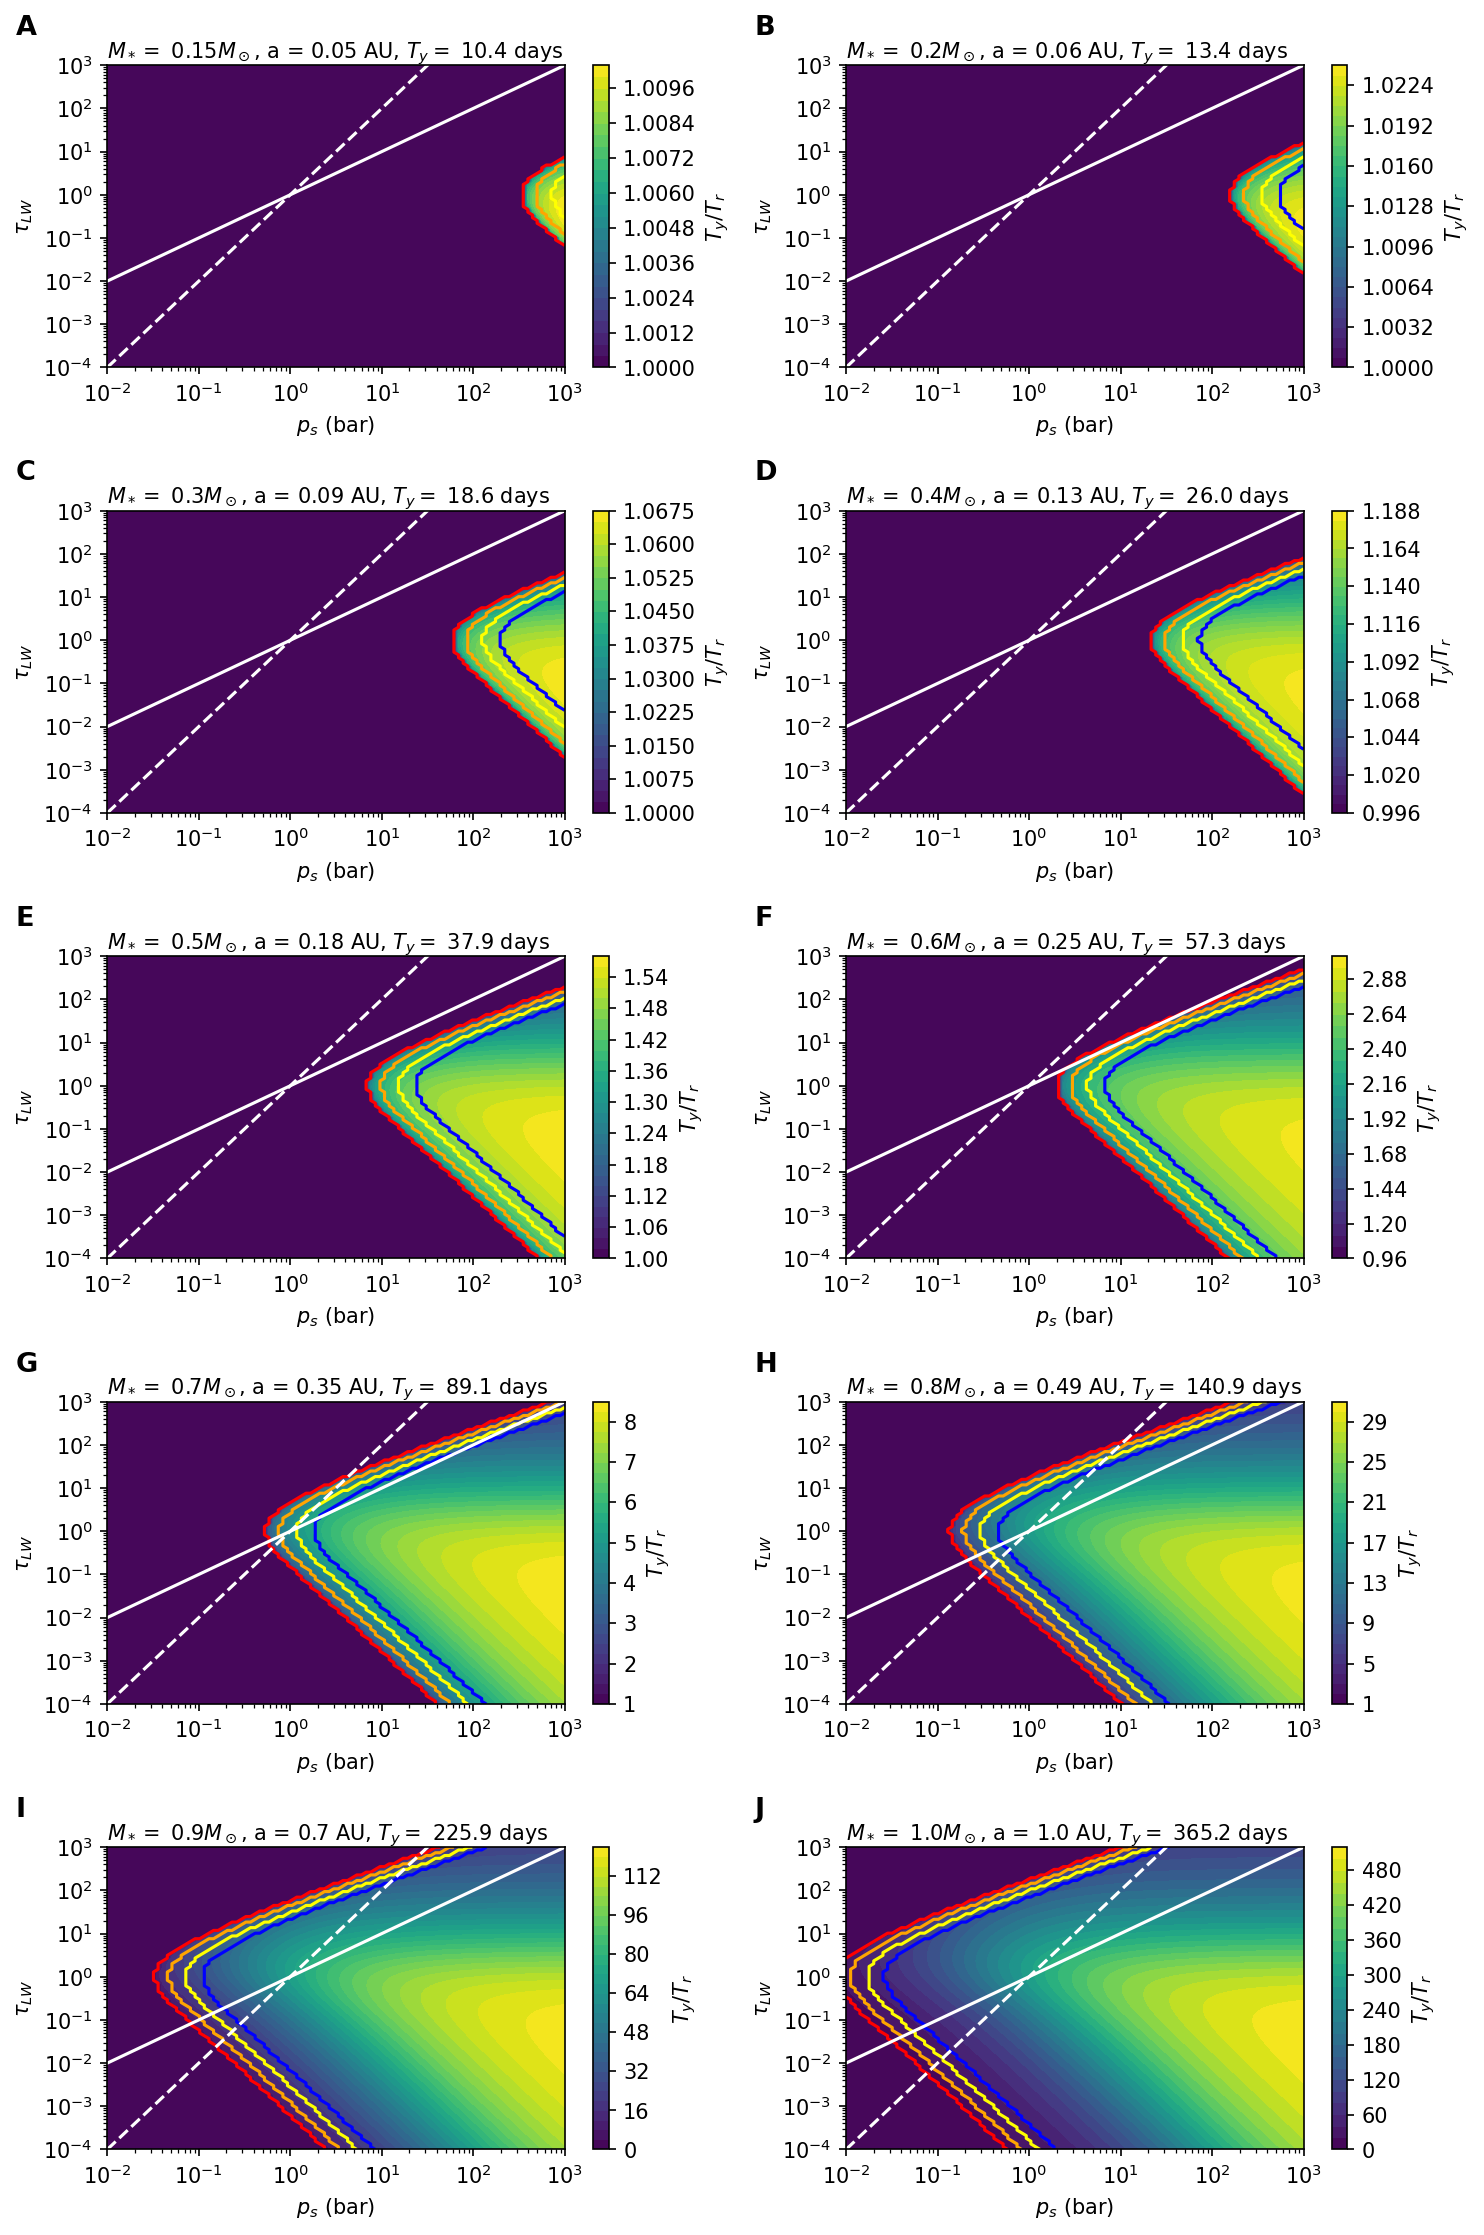

In [135]:
eq_rot_contour_taulwps_plot = eq_rot_contour_taulwps.reshape(5,2,9,110,100)
fig, ax = plt.subplots(5,2, dpi = 150, figsize = (10,15),tight_layout = True)
M_star_list_plot = np.array(M_star_list).reshape(5,2)
letter = [['A','B'],['C','D'],['E','F'],['G','H'],['I','J']]
for i in range(5):
    for j in range(2):
        M = M_star_list_plot[i,j]*M_sun
        mu_star = np.log10(M/M_sun)
        L_star = L_sun*10**(4.101*mu_star**3 + 8.162*mu_star**2 + 7.108*mu_star)
        a_midHZ = AU*(L_star/L_sun)**(1/2)
        orbit_period_midHZ = (a_midHZ**3 * 4* np.pi**2/(G*M))**(1/2)/(60*60*24)
        c = ax[i,j].contourf(ps_contour_list/bar, taulw_contour_list, eq_rot_contour_taulwps_plot[i,j,2], levels = 30, cmap = 'viridis')
        plt.colorbar(c, ax = ax[i,j],label = '$T_y/T_r$')
        ax[i,j].plot(ps_contour_list/bar, 1*ps_contour_list/bar, 'w-')
        ax[i,j].plot(ps_contour_list/bar, 1*(ps_contour_list/bar)**2, 'w--')
        ax[i,j].contour(ps_contour_list/bar, taulw_contour_list, eq_rot_contour_taulwps_plot[i,j,2], levels = [0], colors = 'red')
        ax[i,j].contour(ps_contour_list/bar, taulw_contour_list, eq_rot_contour_taulwps_plot[i,j,5], levels = [0], colors = 'orange')
        ax[i,j].contour(ps_contour_list/bar, taulw_contour_list, eq_rot_contour_taulwps_plot[i,j,7], levels = [0], colors = 'yellow')
        ax[i,j].contour(ps_contour_list/bar, taulw_contour_list, eq_rot_contour_taulwps_plot[i,j,-1], levels = [0], colors = 'blue')
        ax[i,j].text(0.01, 1450, '$M_* = $ ' + str(np.round(M/M_sun,2)) + '$M_\odot$, a = ' + str(np.around(a_midHZ/AU,2)) + ' AU, $T_y = $ ' + str(np.around(orbit_period_midHZ,1)) + ' days')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_ylabel('$\\tau_{LW}$')
        ax[i,j].set_xlabel('$p_s$ (bar)')
        ax[i,j].set_ylim(1e-4, 1e3)
        
        
        
        ax[i,j].text(-0.2, 1.1, np.array(letter)[i,j], transform=ax[i,j].transAxes, size=13, weight='bold')
plt.savefig('./Paper Plots/eq_rot_taulw_ps_alpha.pdf', bbox_inches='tight')

## Figure 6, Equilibrium rotation, $\tau_{SW}$ and $\tau_{SW}$

In [136]:
## tau_sw and ps

tausw_contour_list = 10**np.linspace(-4, 2,110)
ps_contour_list = 10**np.linspace(-2, 3,100)*1e5
alpha_contour_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
M_star_list = [0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
tau_lw = 1
eq_rot_contour_tauswps = np.zeros([len(M_star_list),len(alpha_contour_list),len(tausw_contour_list), len(ps_contour_list)])

for m in range(len(M_star_list)):
    M = M_star_list[m]*M_sun
    mu_star = np.log10(M/M_sun)
    L_star = L_sun*10**(4.101*mu_star**3 + 8.162*mu_star**2 + 7.108*mu_star)
    a_midHZ = AU*(L_star/L_sun)**(1/2)
    orbit_period = (a_midHZ**3 * 4* np.pi**2/(G*M))**(1/2)
    n = 2*np.pi/orbit_period
    for k in range(len(alpha_contour_list)):
        alpha = alpha_contour_list[k]
        for i in range(len(tausw_contour_list)):
            alpha = alpha_contour_list[k]
            for j in range(len(ps_contour_list)):
                tau_sw = tausw_contour_list[i]
                rot = eq_rotation_ana(M, R_E, a_midHZ, alpha, tau_sw, tau_lw, ps_contour_list[j], 90, 100, k2) # returns 2*sigma
                eq_rot_contour_tauswps[m,k,i,j] = (rot/2+n)/(n)



<ipython-input-137-7966519e103b>:17: UserWarning: No contour levels were found within the data range.
  ax[i,j].contour(ps_contour_list/bar, tausw_contour_list, eq_rot_contour_tauswps_plot[i,j,2], levels = [1], colors = 'red')
<ipython-input-137-7966519e103b>:18: UserWarning: No contour levels were found within the data range.
  ax[i,j].contour(ps_contour_list/bar, tausw_contour_list, eq_rot_contour_tauswps_plot[i,j,5], levels = [1], colors = 'orange')
<ipython-input-137-7966519e103b>:19: UserWarning: No contour levels were found within the data range.
  ax[i,j].contour(ps_contour_list/bar, tausw_contour_list, eq_rot_contour_tauswps_plot[i,j,7], levels = [1], colors = 'yellow')
<ipython-input-137-7966519e103b>:20: UserWarning: No contour levels were found within the data range.
  ax[i,j].contour(ps_contour_list/bar, tausw_contour_list, eq_rot_contour_tauswps_plot[i,j,-1], levels = [1], colors = 'blue')
<ipython-input-137-7966519e103b>:17: UserWarning: No contour levels were found withi

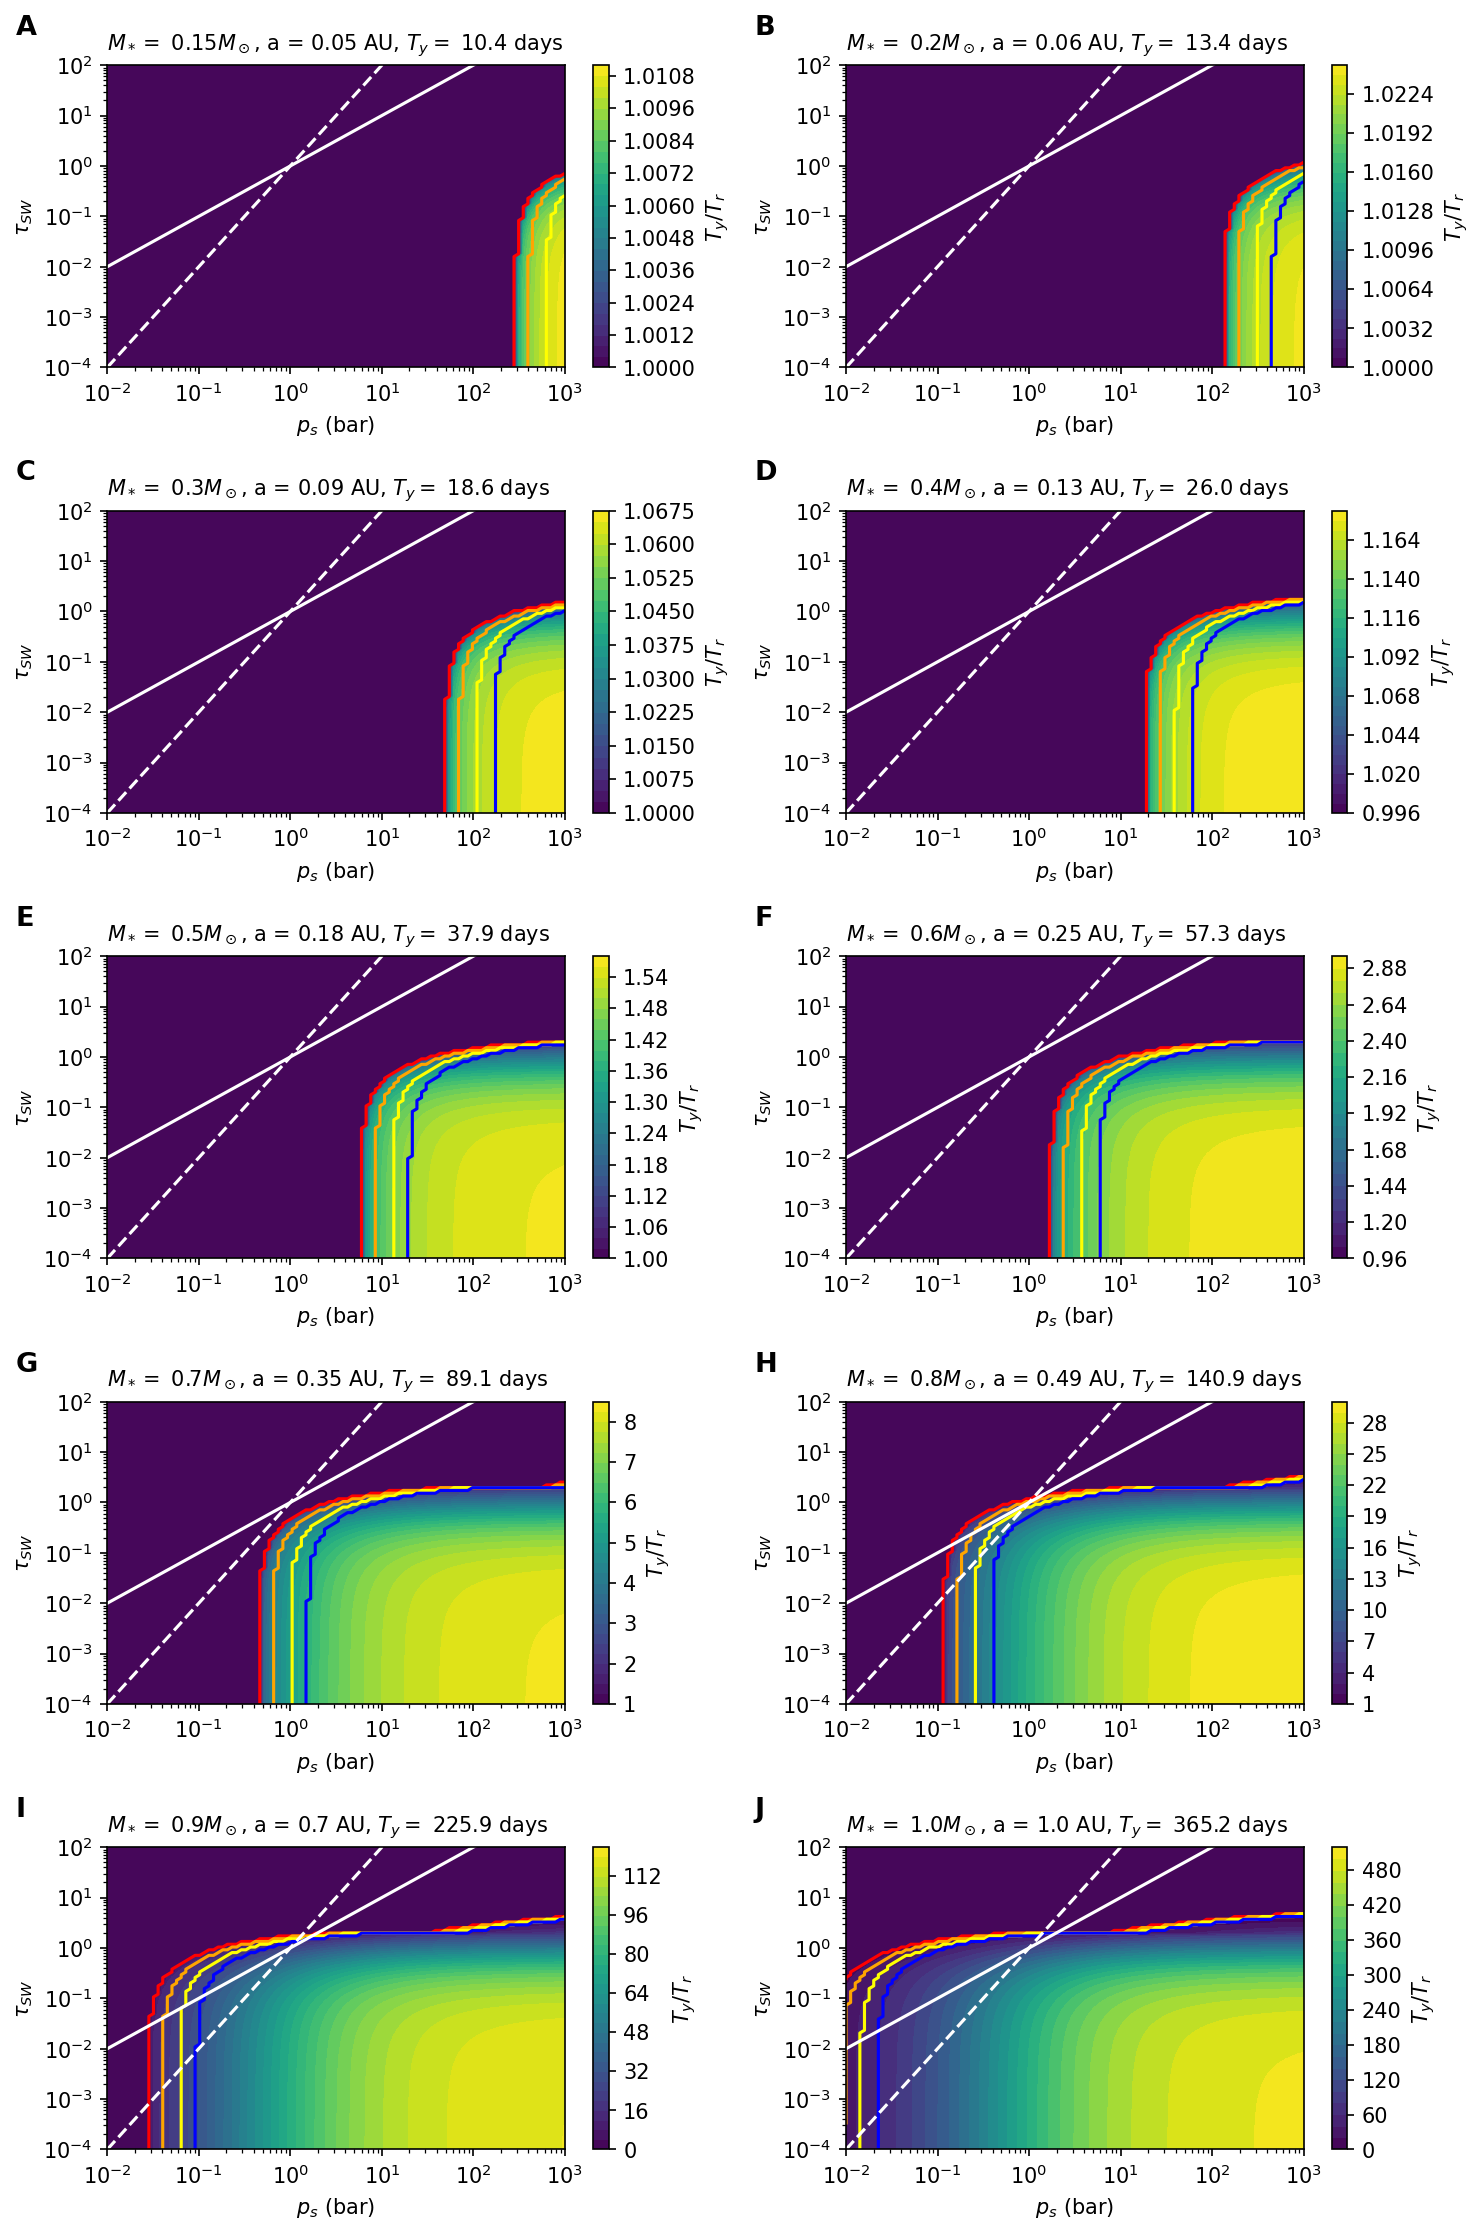

In [137]:
eq_rot_contour_tauswps_plot = eq_rot_contour_tauswps.reshape(5,2,9,110,100)*1
#eq_rot_contour_tauswps_plot[eq_rot_contour_tauswps_plot == 1] = 'nan'
fig, ax = plt.subplots(5,2, dpi = 150, figsize = (10,15),tight_layout = True)
M_star_list_plot = np.array(M_star_list).reshape(5,2)
letter = [['A','B'],['C','D'],['E','F'],['G','H'],['I','J']]
for i in range(5):
    for j in range(2):
        M = M_star_list_plot[i,j]*M_sun
        mu_star = np.log10(M/M_sun)
        L_star = L_sun*10**(4.101*mu_star**3 + 8.162*mu_star**2 + 7.108*mu_star)
        a_midHZ = AU*(L_star/L_sun)**(1/2)
        orbit_period_midHZ = (a_midHZ**3 * 4* np.pi**2/(G*M))**(1/2)/(60*60*24)
        c = ax[i,j].contourf(ps_contour_list/bar, tausw_contour_list, eq_rot_contour_tauswps_plot[i,j,2], levels = 30, cmap = 'viridis')
        plt.colorbar(c, ax = ax[i,j],label = '$T_y/T_r$')
        ax[i,j].plot(ps_contour_list/bar, 1*ps_contour_list/bar, 'w-')
        ax[i,j].plot(ps_contour_list/bar, 1*(ps_contour_list/bar)**2, 'w--')
        ax[i,j].contour(ps_contour_list/bar, tausw_contour_list, eq_rot_contour_tauswps_plot[i,j,2], levels = [1], colors = 'red')
        ax[i,j].contour(ps_contour_list/bar, tausw_contour_list, eq_rot_contour_tauswps_plot[i,j,5], levels = [1], colors = 'orange')
        ax[i,j].contour(ps_contour_list/bar, tausw_contour_list, eq_rot_contour_tauswps_plot[i,j,7], levels = [1], colors = 'yellow')
        ax[i,j].contour(ps_contour_list/bar, tausw_contour_list, eq_rot_contour_tauswps_plot[i,j,-1], levels = [1], colors = 'blue')
        # ax[i,j].text(0.05, 200, '$\\alpha = $' + str(alpha_contour_list[2]), color = 'red')
        # ax[i,j].text(0.05, 100, '$\\alpha = $' + str(alpha_contour_list[5]), color = 'orange')
        # ax[i,j].text(0.05, 45, '$\\alpha = $' + str(alpha_contour_list[7]), color = 'yellow')
        ax[i,j].text(0.01, 200, '$M_* = $ ' + str(np.round(M/M_sun,2)) + '$M_\odot$, a = ' + str(np.around(a_midHZ/AU,2)) + ' AU, $T_y = $ ' + str(np.around(orbit_period_midHZ,1)) + ' days')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_ylabel('$\\tau_{SW}$')
        ax[i,j].set_xlabel('$p_s$ (bar)')
        # ax[i,j].text(0.02, 2e-2, '$\\tau_{LW} \propto p_s$', color ='white')
        # ax[i,j].text(0.2, 1e-3, '$\\tau_{LW} \propto p_s^2$', color ='white')
        ax[i,j].set_ylim(1e-4, 1e2)
        #ax[i,j].title('$M_* = 0.5M_\odot, a = 0.2$ AU')
        
        
        ax[i,j].text(-0.2, 1.1, np.array(letter)[i,j], transform=ax[i,j].transAxes, size=13, weight='bold')
plt.savefig('./Paper Plots/eq_rot_tausw_ps_alpha.pdf', bbox_inches='tight')

## Figure 7, critical semi-major axis

3.827e+26


<ipython-input-123-4728298abe1b>:85: RuntimeWarning: invalid value encountered in power
  return((10*np.pi/3)**(1/6)*np.power(G*M*R_E**2*k2*rho_mean/(qo*Q),1/3)/AU)


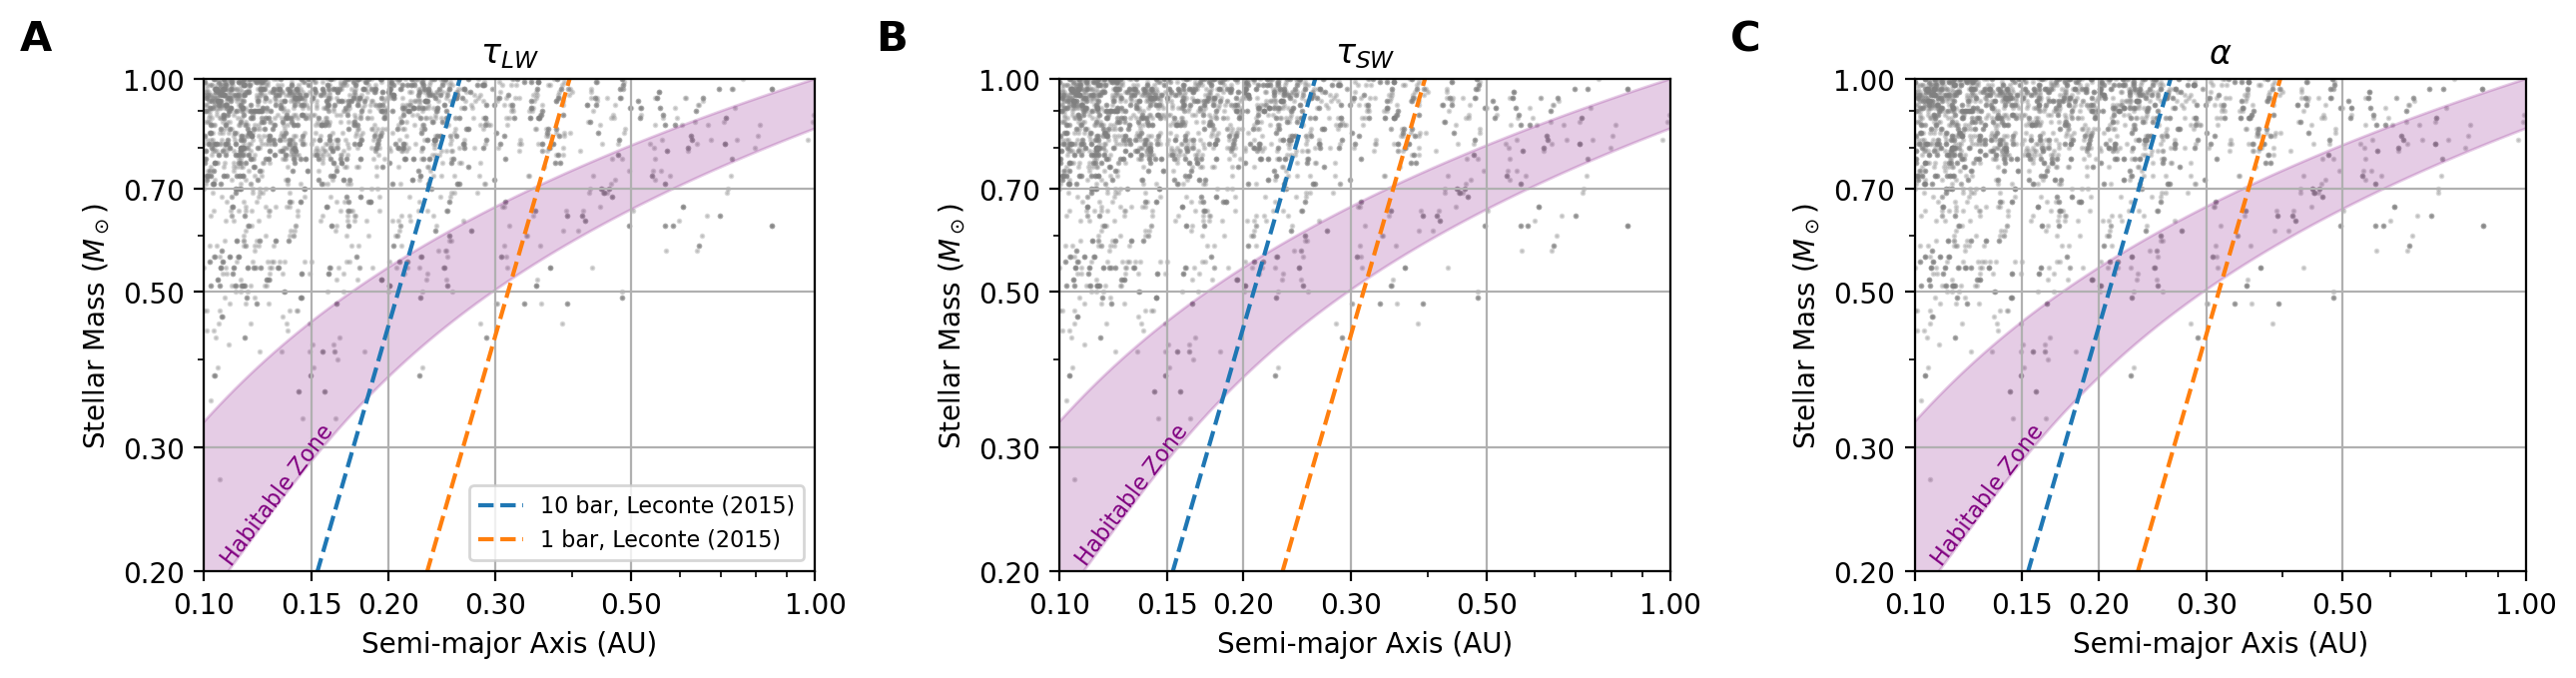

In [138]:
from matplotlib.ticker import StrMethodFormatter, NullFormatter
exo = np.loadtxt('nasa_exoplanet.csv',skiprows=103, usecols=(15,59), delimiter=',')
fig, ax = plt.subplots(1,3,figsize=(13,3.5), dpi=200,tight_layout=True)
M_star_list = np.linspace(0.1,1,100)
print(L_sun)
mu_star = np.log10(M_star_list)
L_star = L_sun*10**(4.101*mu_star**3 + 8.162*mu_star**2 + 7.108*mu_star)
a_inner = np.sqrt(L_star/(4*np.pi*1366))
a_outer = np.sqrt(L_star/(4*np.pi*472))
S_fig7 = 1366
tau_sw_base_1bar = 0.58
tau_sw_base_10bar = 0.65
alpha_plot = 0.3

for axes in ax:
    axes.scatter(exo[:,0], exo[:,1], color ='grey',alpha=0.3, s=1)
    axes.fill_betweenx(M_star_list, a_inner/AU, a_outer/AU, alpha=0.2, color = 'purple')
    axes.plot(critical_semimajor_leconte(M_star_list*M_sun, R_E, 10*bar, 90, 100, k2), M_star_list, '--',label = '10 bar, Leconte (2015)')
    axes.plot(critical_semimajor_leconte(M_star_list*M_sun, R_E, 1*bar, 90, 100, k2), M_star_list, '--',label = '1 bar, Leconte (2015)')
    axes.set_ylabel('Stellar Mass ($M_\\odot$)')
    axes.set_xlabel('Semi-major Axis (AU)')
    axes.text(0.105,0.205, 'Habitable Zone', color='purple', rotation=53, fontsize=8)

    
ax[0].text(0.05, 1.1, 'A', fontweight='bold', fontsize=15)
ax[1].text(0.05, 1.1, 'B', fontweight='bold', fontsize=15)
ax[2].text(0.05, 1.1, 'C', fontweight='bold', fontsize=15)

ax[0].set_title('$\\tau_{LW}$')

ax[0].fill_betweenx(M_star_list, critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, tau_sw_base_1bar, 10, 1*bar, 90, 100, k2), critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, tau_sw_base_1bar, 1, 1*bar, 90, 100, k2), alpha=alpha_plot, color = 'orange')
ax[0].fill_betweenx(M_star_list, critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, tau_sw_base_10bar, 100, 10*bar, 90, 100, k2), critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, tau_sw_base_10bar, 10, 10*bar, 90, 100, k2), alpha=alpha_plot, color = 'blue')


ax[0].legend(fontsize=8)

ax[1].set_title('$\\tau_{SW}$')

ax[1].fill_betweenx(M_star_list, critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, 2, 1, 1*bar, 90, 100, k2), critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, tau_sw_base_1bar, 1, 1*bar, 90, 100, k2), alpha=alpha_plot, color = 'orange')

ax[1].fill_betweenx(M_star_list, critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, 2, 10, 10*bar, 90, 100, k2), critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, tau_sw_base_10bar, 10, 10*bar, 90, 100, k2), alpha=alpha_plot, color = 'blue')

ax[2].set_title('$\\alpha$')

ax[2].fill_betweenx(M_star_list, critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.9, tau_sw_base_1bar, 1, 1*bar, 90, 100, k2), critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, tau_sw_base_1bar, 1, 1*bar, 90, 100, k2), alpha=alpha_plot, color = 'orange')

ax[2].fill_betweenx(M_star_list, critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.9, tau_sw_base_10bar, 10, 10*bar, 90, 100, k2), critical_semimajor(S_fig7,M_star_list*M_sun, R_E, 0.2, tau_sw_base_10bar, 10, 10*bar, 90, 100, k2), alpha=alpha_plot, color = 'blue')





from matplotlib.ticker import StrMethodFormatter, NullFormatter

for axes in ax:
    axes.set_yscale('log')
    axes.set_xscale('log')
    axes.xaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
    axes.xaxis.set_minor_formatter(NullFormatter())
    axes.yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
    axes.yaxis.set_minor_formatter(NullFormatter())
    axes.set_xticks([0.1, 0.15, 0.2, 0.3, 0.5, 1.0])
    axes.set_yticks([0.2, 0.3, 0.5, 0.7, 1.0])
    axes.set_xlim(0.1,1)
    axes.set_ylim(0.2,1.)
    axes.grid()
plt.savefig('./Paper Plots/HZ_crit-a.pdf')